In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [3]:
import json
from tqdm.auto import tqdm
from itertools import islice
from collections import Counter
from textwrap import fill
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

```
../data/verb_morpho.csv 15c7c1
../data/10.02-word-split.json 7ac81e
../data/delta_tenc_d200_biwords.bin 04e3f4
```

In [4]:
from hashlib import sha1
from pathlib import Path
paths = ["../data/verb_morpho.csv",          
         "../data/10.02-word-split.json",
         "../data/delta_tenc_d200_biwords.bin"]
for path_x in paths:
    h = sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6])

../data/verb_morpho.csv 15c7c1
../data/10.02-word-split.json 7ac81e
../data/delta_tenc_d200_biwords.bin 04e3f4


## Load resources

In [5]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Microsoft JhengHei']

In [6]:
from opencc import OpenCC
t2s = OpenCC('t2s').convert

In [7]:
mr_data = pd.read_csv("../data/verb_morpho.csv", index_col=0)
kv = KeyedVectors.load_word2vec_format("../data/delta_tenc_d200_biwords.bin", binary=True)
with open("../data/10.02-word-split.json", "r", encoding="UTF-8") as fin:
    word_split = json.load(fin)

In [8]:
mr_data_train = mr_data.loc[mr_data.token.isin(word_split["train"]),:]
mr_data_test = mr_data.loc[mr_data.token.isin(word_split["test"]),:]

In [9]:
## disable TSNE initializing warnings
import warnings
warnings.filterwarnings('ignore')

## Intruders

In [10]:
freq_c1 = Counter(x[0] for x in kv.key_to_index
                  if len(x) == 2 and "*" not in x).most_common()[:20]
freq_c2 = Counter(x[1] for x in kv.key_to_index
                  if len(x) == 2 and "*" not in x).most_common()[:20]

In [11]:
c1_map = {f"{k}*": [] for k, f in freq_c1}
c2_map = {f"*{k}": [] for k, f in freq_c2}
# cx_map = {**c1_map, **c2_map}
cx_map = {k: [] for k in ["*人", "*山"]}
word_list = []
for tok in kv.key_to_index:
    if len(tok) != 2 or "*" in tok:
        continue
    c1, c2 = list(tok)
    c1 = c1 + "*"
    c2 = "*" + c2
    if c1 in cx_map:
        cx_map[c1].append(tok)
    if c2 in cx_map:
        cx_map[c2].append(tok)
    if c1 in cx_map or c2 in cx_map:
        word_list.append(tok)
len(word_list)

950

In [12]:
for cx, words in cx_map.items():
    mu_vec = np.vstack([kv.get_vector(x, norm=False) for x in words]).mean(axis=0)
    assert np.allclose(mu_vec, kv.get_vector(cx)), cx
    
print("Check pass, we can directly use mu vectors in kv")

Check pass, we can directly use mu vectors in kv


In [13]:
## Build distance matrix
## Dist: mu_vec(centroids) * wordlist
De = np.zeros((len(cx_map), len(word_list)))
Dc = np.zeros((len(cx_map), len(word_list)))

In [14]:
mu_list = list(cx_map.keys())
for i in tqdm(range(len(cx_map))):
    Dc[i, :] = kv.cosine_similarities(kv[mu_list[i]], [kv[x] for x in word_list])
    De[i, :] = cdist([kv[mu_list[i]]], [kv[x] for x in word_list])[0]

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
word_lut = {w: i for i, w in enumerate(word_list)}
mu_lut = {w: i for i, w in enumerate(mu_list)}
mu_zones = {}
for mu_i, mu_x in enumerate(tqdm(mu_list)):
    friends_idxs = [word_lut[w] for w in cx_map[mu_x]]
    friends_set = set(friends_idxs)
    foe_idxs = [idx for idx in range(len(word_list))
                 if idx not in friends_set]
    friends_cosine = Dc[mu_i, friends_idxs]
    friend_range = [.05, .95]
    friend_zone = np.quantile(friends_cosine, friend_range)
    intruders = [(word_list[foe_idx], Dc[mu_i, foe_idx]) 
                 for foe_idx in foe_idxs
                 if friend_zone[0] < Dc[mu_i, foe_idx] < friend_zone[1]]
    mu_zones[mu_x] = {
        "n_friends": len(friends_idxs), 
        "n_intruders": len(intruders),
        "friends": [(word_list[i], Dc[mu_i, i]) for i in friends_idxs],
        "intruders": intruders,
        "friend_range": friend_range,
        "friend_zone": friend_zone
    }
    

  0%|          | 0/2 [00:00<?, ?it/s]

## Dc distributions

*人


Text(0.5, 1.0, '*人 cosine similarity distribution')

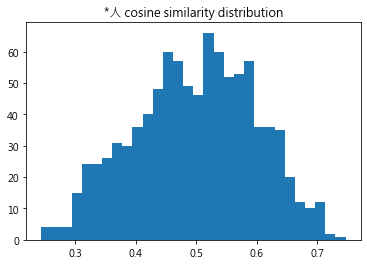

In [16]:
print(mu_list[0])
plt.hist(Dc[0,:], 30)
plt.title(mu_list[0] + " cosine similarity distribution")

*山


(array([ 1.,  1.,  3.,  8., 12., 22., 46., 54., 81., 76., 65., 59., 71.,
        49., 48., 34., 21., 16., 18., 21., 33., 34., 34., 36., 38., 25.,
        17., 16.,  9.,  2.]),
 array([0.08381879, 0.10978411, 0.13574942, 0.16171474, 0.18768006,
        0.21364538, 0.2396107 , 0.26557602, 0.29154134, 0.31750666,
        0.34347198, 0.3694373 , 0.39540262, 0.42136794, 0.44733326,
        0.47329858, 0.4992639 , 0.52522921, 0.55119453, 0.57715985,
        0.60312517, 0.62909049, 0.65505581, 0.68102113, 0.70698645,
        0.73295177, 0.75891709, 0.78488241, 0.81084773, 0.83681305,
        0.86277837]),
 <BarContainer object of 30 artists>)

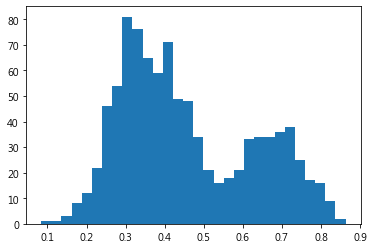

In [17]:
print(mu_list[1])
plt.hist(Dc[1,:], 30)

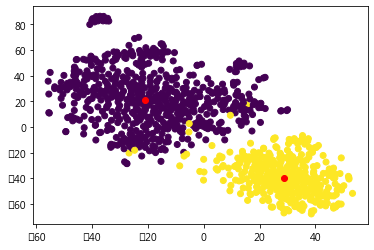

In [18]:
tsne_proj = TSNE()
vecs = np.vstack([kv.get_vector(x) for x in mu_list] + [kv.get_vector(x) for x in word_list])
ylabel = mu_list + ["*"+x[1] for x in word_list]
yset = list(cx_map)
tsne = tsne_proj.fit_transform(vecs)
plt.scatter(tsne[:,0], tsne[:,1], c=[yset.index(x) for x in ylabel])
plt.scatter(tsne[:2,0], tsne[:2,1], color='#F00')
# purple: *人, yellow: *山 

Text(0.5, 1.0, '*人 Euclidean distance distribution (TSNE)')

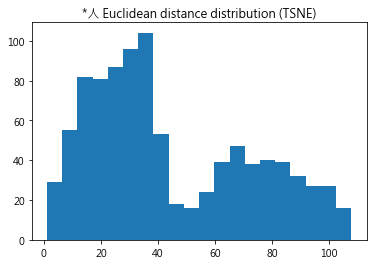

In [19]:
d_tsne = cdist([tsne[0,:]], tsne[2:,:])[0]
plt.hist(d_tsne, 20)
plt.title(mu_list[0] + " Euclidean distance distribution (TSNE)")

Text(0.5, 1.0, '*山 Euclidean distance distribution (TSNE)')

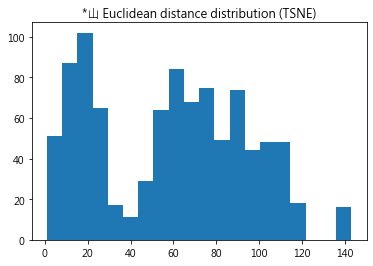

In [20]:
d_tsne = cdist([tsne[1,:]], tsne[2:,:])[0]
plt.hist(d_tsne, 20)
plt.title(mu_list[1] + " Euclidean distance distribution (TSNE)")